# Audio segmentation

A tutorial on audio segmentation for machine learning applications.

When working with audio in ML, it is often the case that the audio file that you would want to extract features from contains a lot more than the small snippet(s) of audio that you are actually interested in, it might be long periods of silence, background noise or just some other sound that you are not really interested in. In this tutorial I'm going to show a very simple way of extracting the audio that you really care about.

### Start with importing the dependencies

In [1]:
from pathlib import Path

import IPython.display as ipd
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

AUDIO = Path('audio')

### A first very simple example
We'll start by looking (and listening) to an audio clip featuring a dog bark made by my dog Astrid. We will load in the file, plot the data (the waveform) and listen to it

In [2]:
fname = AUDIO / 'astrid_one_bark.wav'
waveform, sample_rate = sf.read(fname)

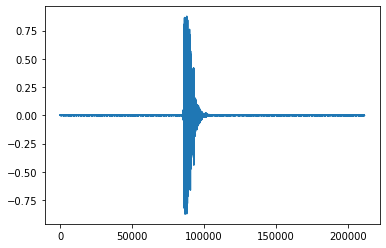

In [3]:
plt.plot(waveform)

In [4]:
ipd.Audio(waveform, rate=sample_rate)

As we can see and hear, there is a lot of silence before and after the bark. This gives no extra information and would probably only confuse a classifier if we trained it on samples like this. Maybe it would learn that there should always be some silence before and after the actual sound in order for it to be a dog bark? 

What we would like to do is to extract the relevant part of the audio clip. We can do that by looking at smaller segments of the wavform, one at a time, and selecting the segment that has the most energy (the segment with the "most" signal in it). The first thing we will do is to define the length of each segment:

In [5]:
segment_len = sample_rate * 1 # each segment is one second long

We will then select the segment of the waveform that starts at time zero and is `segment_len` long

40.59442138671875


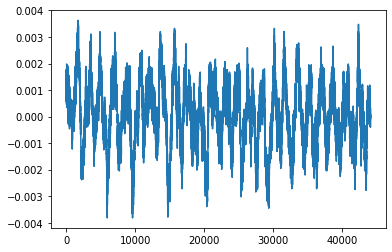

In [6]:
start_idx_1 = 0 # start at time zero

segment_1 = waveform[start_idx_1:start_idx_1+segment_len]
energy_1 = np.sum(np.abs(segment_1))

print(energy_1)
plt.plot(segment_1)

The energy is about 40, that doesn't tell us a lot... Let's look at another segment. We choose a new starting point and then we do the same thing again

632.740966796875


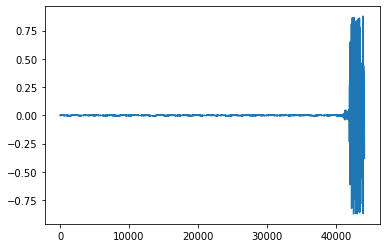

In [7]:
start_idx_2 = 1 * sample_rate # 1 second into the clip

segment_2 = waveform[start_idx_2:start_idx_2+segment_len]
energy_2 = np.sum(np.abs(segment_2))

print(energy_2)
plt.plot(segment_2)

we see that `energy_2` is a lot bigger than `energy_1`, so let's keep `segment_2` as our current segment with the most energy. We should then continue to look at all other possible segments in our waveform, and finally select the one with the most energy as our target segment. It would be very tedious to continue to do this manually, so instead we are going to write a function to do it for us. First, we will write a function that just splits a waveform into a list of possible segments

In [8]:
def split_into_segments(waveform, segment_len, hop_len):
    segments = []
    if len(waveform) > segment_len:
        i = 0
        while i + segment_len < len(waveform):
                new_segment = waveform[i:i+segment_len]
                segments.append(new_segment)
                i += int(hop_len)
    else:
        segments.append(waveform)
    return segments

`segment_len` is the length of each segment and `hop_len` is the distance between two adjacent segments. Having `hop_len < segment_len` means that the resulting segments are overlappping. Now, we can easily get the segment with the highest energy

In [9]:
segment_len = 1 * sample_rate # segments are one second long
hop_len = segment_len / 4 # adjacent segments have 75% overlap

all_segments = split_into_segments(waveform, segment_len, hop_len)
all_energies = [np.sum(np.abs(seg)) for seg in all_segments]

max_segment = all_segments[np.argmax(all_energies)]

In [10]:
ipd.Audio(max_segment, rate=sample_rate)

If we compare this plot with the first plot, we see that we have found the segment with the most energy.

### More than one interesting segment in a single file

It might be the case that a file contains not only one but multiple events that are of interest, and we would like to extract all segments with enough energy. We can do this by comparing the energy of each segment with the energy of the segment with maximum energy, and keep a segment if it has an energy sufficiently close to that of the maximum segment. For example, we can choose to keep all segments with an energy of at least 60% of that of the maximum segment. Let's look at another audio clip

In [11]:
fname = AUDIO / 'astrid_multiple_barks.wav'
waveform, sample_rate = sf.read(fname)

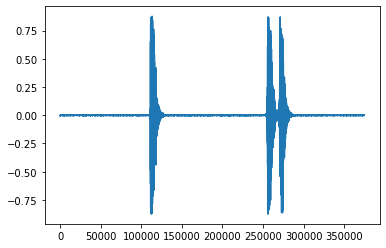

In [12]:
plt.plot(waveform)

In [13]:
ipd.Audio(waveform, rate=sample_rate)

We follow the same procedure as before

In [14]:
segment_len = 1 * sample_rate # segments are one second long
hop_len = segment_len / 2 # adjacent segments have 50% overlap

candidates = split_into_segments(waveform, segment_len, hop_len)
energies = [np.sum(np.abs(seg)) for seg in candidates]

In [15]:
max_energy = np.max(energies)
min_energy_frac = 0.5

segments_to_keep = [seg for seg, energy in zip(candidates, energies) if energy/max_energy > min_energy_frac]

print(len(segments_to_keep))

5


We found five segments with enough energy for them to be of interest. But how is it that we find five segments when the clip only seems to contain two short segments of interest? It's because we have a lot of overlap between segments, so every bark can be in more than one segment, each being slighly shifted in time from the others. This can actually be great if we want to train a classifier, because we essentially get a lot of different augmentations of the same sound. But if you are not interested in those duplicates, we can just adjust `hop_len` and `min_energy_frac` until we are happy. We can now listen to the five found segments

In [16]:
ipd.Audio(segments_to_keep[0], rate=sample_rate)

In [17]:
ipd.Audio(segments_to_keep[1], rate=sample_rate)

In [18]:
ipd.Audio(segments_to_keep[2], rate=sample_rate)

In [19]:
ipd.Audio(segments_to_keep[3], rate=sample_rate)

In [20]:
ipd.Audio(segments_to_keep[4], rate=sample_rate)